### Notebook for the epithelial label transfer of Reference epithelial dataset (GCA + Kong + Wang + Smillie) to rest of epithelial cells from GCA using `scANVI`

- **Developed by:** Anna Maguza
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- 11th April 2022

### Load required modules

In [1]:
import sys
import scvi
import torch
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import scipy as sp
import pandas as pd
import scanpy as sc
import numpy.random as random


from umap import UMAP
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt

/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarnin

In [2]:
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [3]:
torch.cuda.is_available()

False

In [4]:
torch.set_float32_matmul_precision('medium')

In [5]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
absl                        NA
appnope                     0.1.2
asttokens                   NA
attr                        22.2.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      NA
certifi                     2022.12.07
cffi                        1.15.1
charset_normalizer          2.1.1
chex                        0.1.6
colorama                    0.4.6
comm                        0.1.2
contextlib2                 NA
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
entrypoints                 0.4
executing                   0.8.3
flax                        0.6.1
fsspec                      2023.3.0
h5py                        3.8.0
hypergeom_uf

In [6]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

In [7]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in Reference object

In [8]:
#Save the anndata_subset object - local machine path
reference_input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Geosketch_subsets/Epithelial_cells/Epithelial_cells_Geosketch_subset_reference_with_Kong.h5ad'
reference = sc.read_h5ad(reference_input)
reference.X

<72662x23616 sparse matrix of type '<class 'numpy.float32'>'
	with 159951157 stored elements in Compressed Sparse Row format>

In [9]:
reference.obs['seed_labels'] = reference.obs['Cell States GCA'].copy()

### Select HVGs

In [10]:
X_is_raw(reference)

True

In [11]:
sc.pp.filter_genes(reference, min_cells = 3)

filtered out 1805 genes that are detected in less than 3 cells


In [12]:
reference.obs["Donor_ID"].value_counts()

A34 (417C)    8956
A32 (411C)    4909
A26 (386C)    4243
F72           4132
BRC2121       4104
              ... 
N49              4
T036NEG          3
N12              3
106265           2
T110NEG          1
Name: Donor_ID, Length: 78, dtype: int64

In [13]:
# delete donor with only 1 cell
reference = reference[reference.obs["Donor_ID"] != "T110NEG"]

In [15]:
reference.layers['counts'] = reference.X.copy()

In [17]:
sc.pp.highly_variable_genes(
    reference,
    flavor = "seurat_v3",
    n_top_genes = 5000,
    layer = "counts",
    batch_key = "Donor_ID",
    subset = True,
    span = 1
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


### Read query object

In [18]:
#Save the anndata_subset object - local machine path
query_input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Geosketch_subsets/Epithelial_cells/Epithelial_cells_Geosketch_subset_query_with_Kong.h5ad'
query = sc.read_h5ad(reference_input)
query.X

<72662x23616 sparse matrix of type '<class 'numpy.float32'>'
	with 159951157 stored elements in Compressed Sparse Row format>

In [19]:
query.obs['seed_labels'] = 'Unknown'

In [20]:
# Concatenate reference and query
adata = reference.concatenate(query, batch_key = 'dataset', batch_categories = ['reference', 'query'])

In [21]:
adata.layers['counts'] = adata.X.copy()

In [22]:
adata.var

n_cells-reference  highly_variable-reference  \
SAMD11                       454                       True   
NOC2L                      18929                       True   
HES4                        9082                       True   
ISG15                      12148                       True   
RP11-465B22.5                 14                       True   
...                          ...                        ...   
KCNC2                         49                       True   
SERPINA12                     27                       True   
IER3IP1                    19982                       True   
VGLL1                         18                       True   
GLYAT                         46                       True   

               highly_variable_rank-reference  means-reference  \
SAMD11                                  577.0         0.009138   
NOC2L                                  1780.0         0.352899   
HES4                                    409.0         0.239482   
ISG15                                   879.5         0.357565   
RP11-465B22.5                          1121.0         0.000234   
...                                       ...              ...   
KCNC2                                   801.0         0.000757   
SERPINA12                               758.0         0.000551   
IER3IP1                                1452.0         0.437786   
VGLL1                                  1695.0         0.000289   
GLYAT                                  1332.0         0.000784   

               variances-reference  variances_norm-reference  \
SAMD11                    0.020808                  0.622482   
NOC2L                     0.477718                  0.940797   
HES4                      0.812163                  1.565306   
ISG15                     3.259278                  1.263104   
RP11-465B22.5             0.000316                  0.110228   
...                            ...                       ...   
KCNC2                     0.000922                  0.149747   
SERPINA12                 0.001486                  0.099092   
IER3IP1                   0.760749                  0.765756   
VGLL1                     0.000399                  0.072614   
GLYAT                     0.001279                  0.111160   

               highly_variable_nbatches-reference  
SAMD11                                         21  
NOC2L                                          21  
HES4                                           65  
ISG15                                          54  
RP11-465B22.5                                   3  
...                                           ...  
KCNC2                                           4  
SERPINA12                                       4  
IER3IP1                                        17  
VGLL1                                           3  
GLYAT                                           2  

[5000 rows x 7 columns]

In [23]:
adata.obs

Cell Type batch  \
cell_id                                                          
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference  Epithelial   GCA   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference  Epithelial   GCA   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  Epithelial   GCA   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference  Epithelial   GCA   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference  Epithelial   GCA   
...                                                  ...   ...   
N110.LPA.TCGGGACGTCAACTGT-query                Stem Cell   GCA   
N110.LPA.TGAGCATTCCAGTAGT-query                Stem Cell   GCA   
N110.LPA.TGGCCAGAGAGGACGG-query                Stem Cell   GCA   
N110.LPA.TTCTTAGCAGTCCTTC-query                Stem Cell   GCA   
N110.LPA.TTTATGCAGACTACAA-query                Stem Cell   GCA   

                                                       Sample_ID n_genes  \
cell_id                                                                    
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP    2288   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP    1244   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP    3431   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP     572   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP    1095   
...                                                          ...     ...   
N110.LPA.TCGGGACGTCAACTGT-query                         N110.LPA    1232   
N110.LPA.TGAGCATTCCAGTAGT-query                         N110.LPA    3181   
N110.LPA.TGGCCAGAGAGGACGG-query                         N110.LPA    4380   
N110.LPA.TTCTTAGCAGTCCTTC-query                         N110.LPA    3634   
N110.LPA.TTTATGCAGACTACAA-query                         N110.LPA    2094   

                                             n_counts Chem  Location Donor_ID  \
cell_id                                                                         
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference   8606.0  nan  SmallInt     T036   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference   3152.0  nan  SmallInt     T036   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  14716.0  nan  SmallInt     T036   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference   1283.0  nan  SmallInt     T036   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference   2194.0  nan  SmallInt     T036   
...                                               ...  ...       ...      ...   
N110.LPA.TCGGGACGTCAACTGT-query                  4384  nan        LP     N110   
N110.LPA.TGAGCATTCCAGTAGT-query                 15655  nan        LP     N110   
N110.LPA.TGGCCAGAGAGGACGG-query                 26921  nan        LP     N110   
N110.LPA.TTCTTAGCAGTCCTTC-query                 22468  nan        LP     N110   
N110.LPA.TTTATGCAGACTACAA-query                 11357  nan        LP     N110   

                                             Layer     Cell States  ...  \
cell_id                                                             ...   
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference   nan  Stem_Cells_GCA  ...   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference   nan     Goblet cell  ...   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference   nan  Stem_Cells_GCA  ...   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference   nan  L cells (PYY+)  ...   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference   nan            Tuft  ...   
...                                            ...             ...  ...   
N110.LPA.TCGGGACGTCAACTGT-query                nan  Stem_Cells_ext  ...   
N110.LPA.TGAGCATTCCAGTAGT-query                nan  Stem_Cells_ext  ...   
N110.LPA.TGGCCAGAGAGGACGG-query                nan  Stem_Cells_ext  ...   
N110.LPA.TTCTTAGCAGTCCTTC-query                nan  Stem_Cells_ext  ...   
N110.LPA.TTTATGCAGACTACAA-query                nan  Stem_Cells_ext  ...   

                                                  Study_name  Age_group  \
cell_id                                                                   
ACGCCAGCAGCCAATT-1-

In [24]:
del reference, query

#### Batch Preparation


In [25]:
# Replace the "nan" or "NaN" string in the Sample_ID column
adata.obs['Sample_ID'] = adata.obs.apply(
    lambda row: row['Sample_ID'] if row['Sample_ID'].lower() != "nan" else
    (row['Donor_ID'] + '_' + str(row['Age']) + '_' + row['Region code'] + '_' + str(row['Fraction'])),
    axis=1
)

In [26]:
adata.obs['Donor_ID'] = adata.obs['Donor_ID'].astype('str')
adata.obs['Age'] = adata.obs['Age'].astype('str')
adata.obs['Region code'] = adata.obs['Region code'].astype('str')
adata.obs['Fraction'] = adata.obs['Fraction'].astype('str')

In [27]:
adata.obs['Sample_ID'] = adata.obs['Sample_ID'].where(
    pd.notna(adata.obs['Sample_ID']),
    adata.obs['Donor_ID'] + '_' + adata.obs['Age'].astype(str) + '_' +
    adata.obs['Region code'] + '_' + adata.obs['Fraction'].astype(str)
)

In [30]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [31]:
del adata.obs['pct_counts_in_top_500_genes'], adata.obs['pct_counts_in_top_200_genes'], adata.obs['pct_counts_in_top_100_genes'], adata.obs['pct_counts_in_top_50_genes'], adata.obs['log1p_total_counts'], adata.obs['log1p_n_genes_by_counts'], adata.obs['n_genes'], adata.obs['n_counts']

In [32]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 145323 × 5000
    obs: 'Cell Type', 'batch', 'Sample_ID', 'Chem', 'Location', 'Donor_ID', 'Layer', 'Cell States', 'Gender', 'library_preparation_protocol__ontology_label', 'Diagnosis', 'n_genes_by_counts', 'total_counts_mito', 'percent_mito', 'total_counts_ribo', 'percent_ribo', 'doublet_scores', 'predicted_doublets', 'Study_name', 'Age_group', 'Cell States Kong', 'UniqueCell_ID', 'Age', 'Region code', 'Fraction', 'Cell States GCA', 'seed_labels', 'dataset', 'total_counts'
    var: 'n_cells-reference', 'highly_variable-reference', 'highly_variable_rank-reference', 'means-reference', 'variances-reference', 'variances_norm-reference', 'highly_variable_nbatches-reference', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'>

### Transfer of annotation with scANVI

In [33]:
scvi.model.SCVI.setup_anndata(adata, 
                              layer = "counts", 
                              labels_key = "seed_labels", 
                              categorical_covariate_keys = ["Donor_ID", "Sample_ID"],
                              continuous_covariate_keys = ["n_genes_by_counts", "total_counts"])

In [34]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [35]:
scvi_model.train(150)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 150/150: 100%|██████████| 150/150 [3:12:20<00:00, 108.51s/it, loss=2.3e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [3:12:20<00:00, 76.94s/it, loss=2.3e+03, v_num=1] 


In [36]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

### Label transfer with `scANVI` 

In [37]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [38]:
scanvi_model.train(50)

INFO     Training for 50 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 50/50: 100%|██████████| 50/50 [2:16:52<00:00, 160.46s/it, loss=2.42e+03, v_num=1]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [2:16:52<00:00, 164.24s/it, loss=2.42e+03, v_num=1]


In [39]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [40]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [43]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:45)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:09)


In [44]:
adata.obs

Cell Type batch  \
cell_id                                                          
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference  Epithelial   GCA   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference  Epithelial   GCA   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  Epithelial   GCA   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference  Epithelial   GCA   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference  Epithelial   GCA   
...                                                  ...   ...   
N110.LPA.TCGGGACGTCAACTGT-query                Stem Cell   GCA   
N110.LPA.TGAGCATTCCAGTAGT-query                Stem Cell   GCA   
N110.LPA.TGGCCAGAGAGGACGG-query                Stem Cell   GCA   
N110.LPA.TTCTTAGCAGTCCTTC-query                Stem Cell   GCA   
N110.LPA.TTTATGCAGACTACAA-query                Stem Cell   GCA   

                                                       Sample_ID Chem  \
cell_id                                                                 
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP  nan   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP  nan   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP  nan   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP  nan   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference  T036-TIL-SC-EPCAMP  nan   
...                                                          ...  ...   
N110.LPA.TCGGGACGTCAACTGT-query                         N110.LPA  nan   
N110.LPA.TGAGCATTCCAGTAGT-query                         N110.LPA  nan   
N110.LPA.TGGCCAGAGAGGACGG-query                         N110.LPA  nan   
N110.LPA.TTCTTAGCAGTCCTTC-query                         N110.LPA  nan   
N110.LPA.TTTATGCAGACTACAA-query                         N110.LPA  nan   

                                              Location Donor_ID Layer  \
cell_id                                                                 
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference  SmallInt     T036   nan   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference  SmallInt     T036   nan   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  SmallInt     T036   nan   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference  SmallInt     T036   nan   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference  SmallInt     T036   nan   
...                                                ...      ...   ...   
N110.LPA.TCGGGACGTCAACTGT-query                     LP     N110   nan   
N110.LPA.TGAGCATTCCAGTAGT-query                     LP     N110   nan   
N110.LPA.TGGCCAGAGAGGACGG-query                     LP     N110   nan   
N110.LPA.TTCTTAGCAGTCCTTC-query                     LP     N110   nan   
N110.LPA.TTTATGCAGACTACAA-query                     LP     N110   nan   

                                                 Cell States Gender  \
cell_id                                                               
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference  Stem_Cells_GCA   Male   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference     Goblet cell   Male   
ACGCCGAGTTCCCGAG-1-4918STDY7333456-reference  Stem_Cells_GCA   Male   
ACGGGCTCACCAGGTC-1-4918STDY7333456-reference  L cells (PYY+)   Male   
ACGGGTCGTAGCAAAT-1-4918STDY7333456-reference            Tuft   Male   
...                                                      ...    ...   
N110.LPA.TCGGGACGTCAACTGT-query               Stem_Cells_ext    nan   
N110.LPA.TGAGCATTCCAGTAGT-query               Stem_Cells_ext    nan   
N110.LPA.TGGCCAGAGAGGACGG-query               Stem_Cells_ext    nan   
N110.LPA.TTCTTAGCAGTCCTTC-query               Stem_Cells_ext    nan   
N110.LPA.TTTATGCAGACTACAA-query               Stem_Cells_ext    nan   

                                             library_preparation_protocol__ontology_label  \
cell_id                                                                                     
ACGCCAGCAGCCAATT-1-4918STDY7333456-reference                                           3'   
ACGCCGAGTGAGGCTA-1-4918STDY7333456-reference                                         

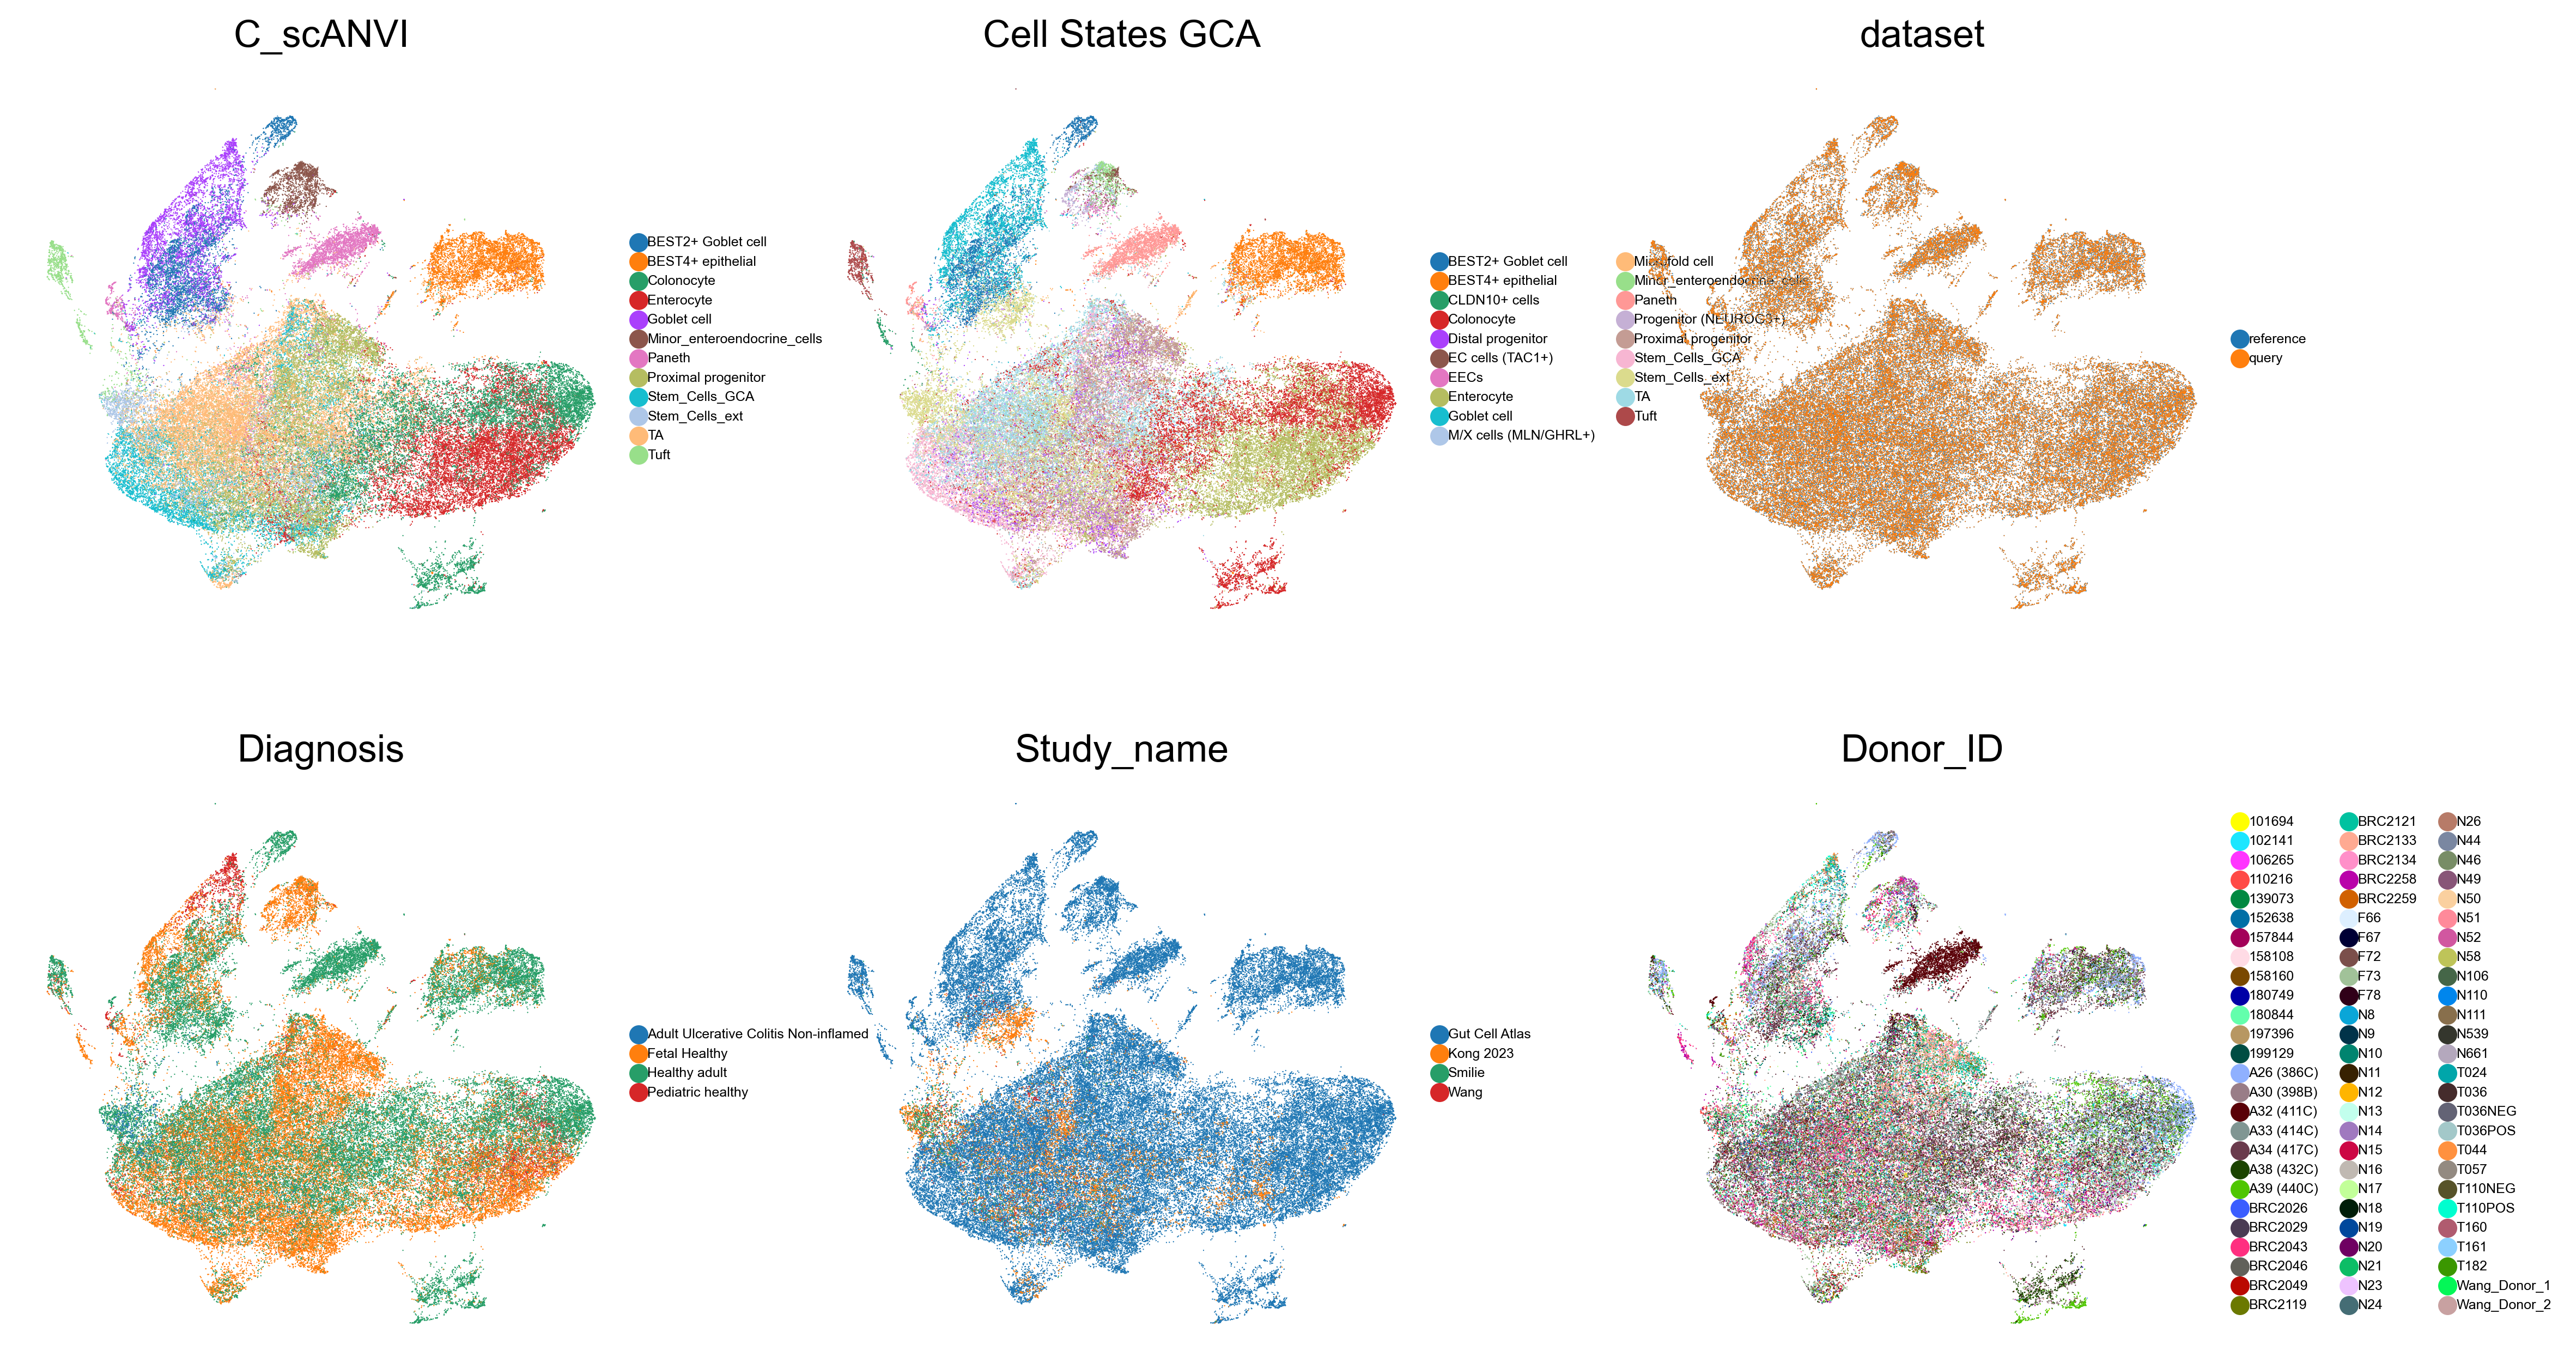

In [45]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'Cell States GCA', 'dataset', 'Diagnosis', 'Study_name', 'Donor_ID'], size = 0.6, legend_fontsize = 5, ncols = 3)

In [42]:
#Write anndata object to file - local machine path
adata.write_h5ad('/Users/anna.maguza/Desktop/Data/Processed_datasets/post_SCANVI/Epithelial/Epithelial_cells_after_scanvi_with_Kong_5K_HVGs_Donor_and_Sample_batch.h5ad')

### Models Validation

In [46]:
input_file = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Epithelial_cells_after_scanvi2.h5ad'
output_file = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Epithelial_cells_after_scanvi_output.h5ad'
adata = sc.read_h5ad(input_file)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Epithelial_cells_after_scanvi2.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [47]:
adata.obs['C_scANVI'].value_counts()

TA                             27420
Proximal progenitor            20808
Enterocyte                     20324
Colonocyte                     19672
Stem_Cells_GCA                 14398
BEST4+ epithelial               9142
Goblet cell                     8840
BEST2+ Goblet cell              7208
Paneth                          6683
Stem_Cells_ext                  5014
Minor_enteroendocrine_cells     3346
Tuft                            2468
Name: C_scANVI, dtype: int64

In [48]:
adata.obs['Cell States GCA'].value_counts()

TA                             20000
Colonocyte                     20000
Enterocyte                     20000
Proximal progenitor            17160
Stem_Cells_ext                 13818
Stem_Cells_GCA                 13818
BEST4+ epithelial               8800
Goblet cell                     7930
BEST2+ Goblet cell              5850
Paneth                          5821
Distal progenitor               5550
Tuft                            1376
Minor_enteroendocrine_cells     1258
Microfold cell                   860
EC cells (TAC1+)                 774
EECs                             742
Progenitor (NEUROG3+)            584
M/X cells (MLN/GHRL+)            536
CLDN10+ cells                    446
Name: Cell States GCA, dtype: int64

Text(0, 0.5, 'Observed')

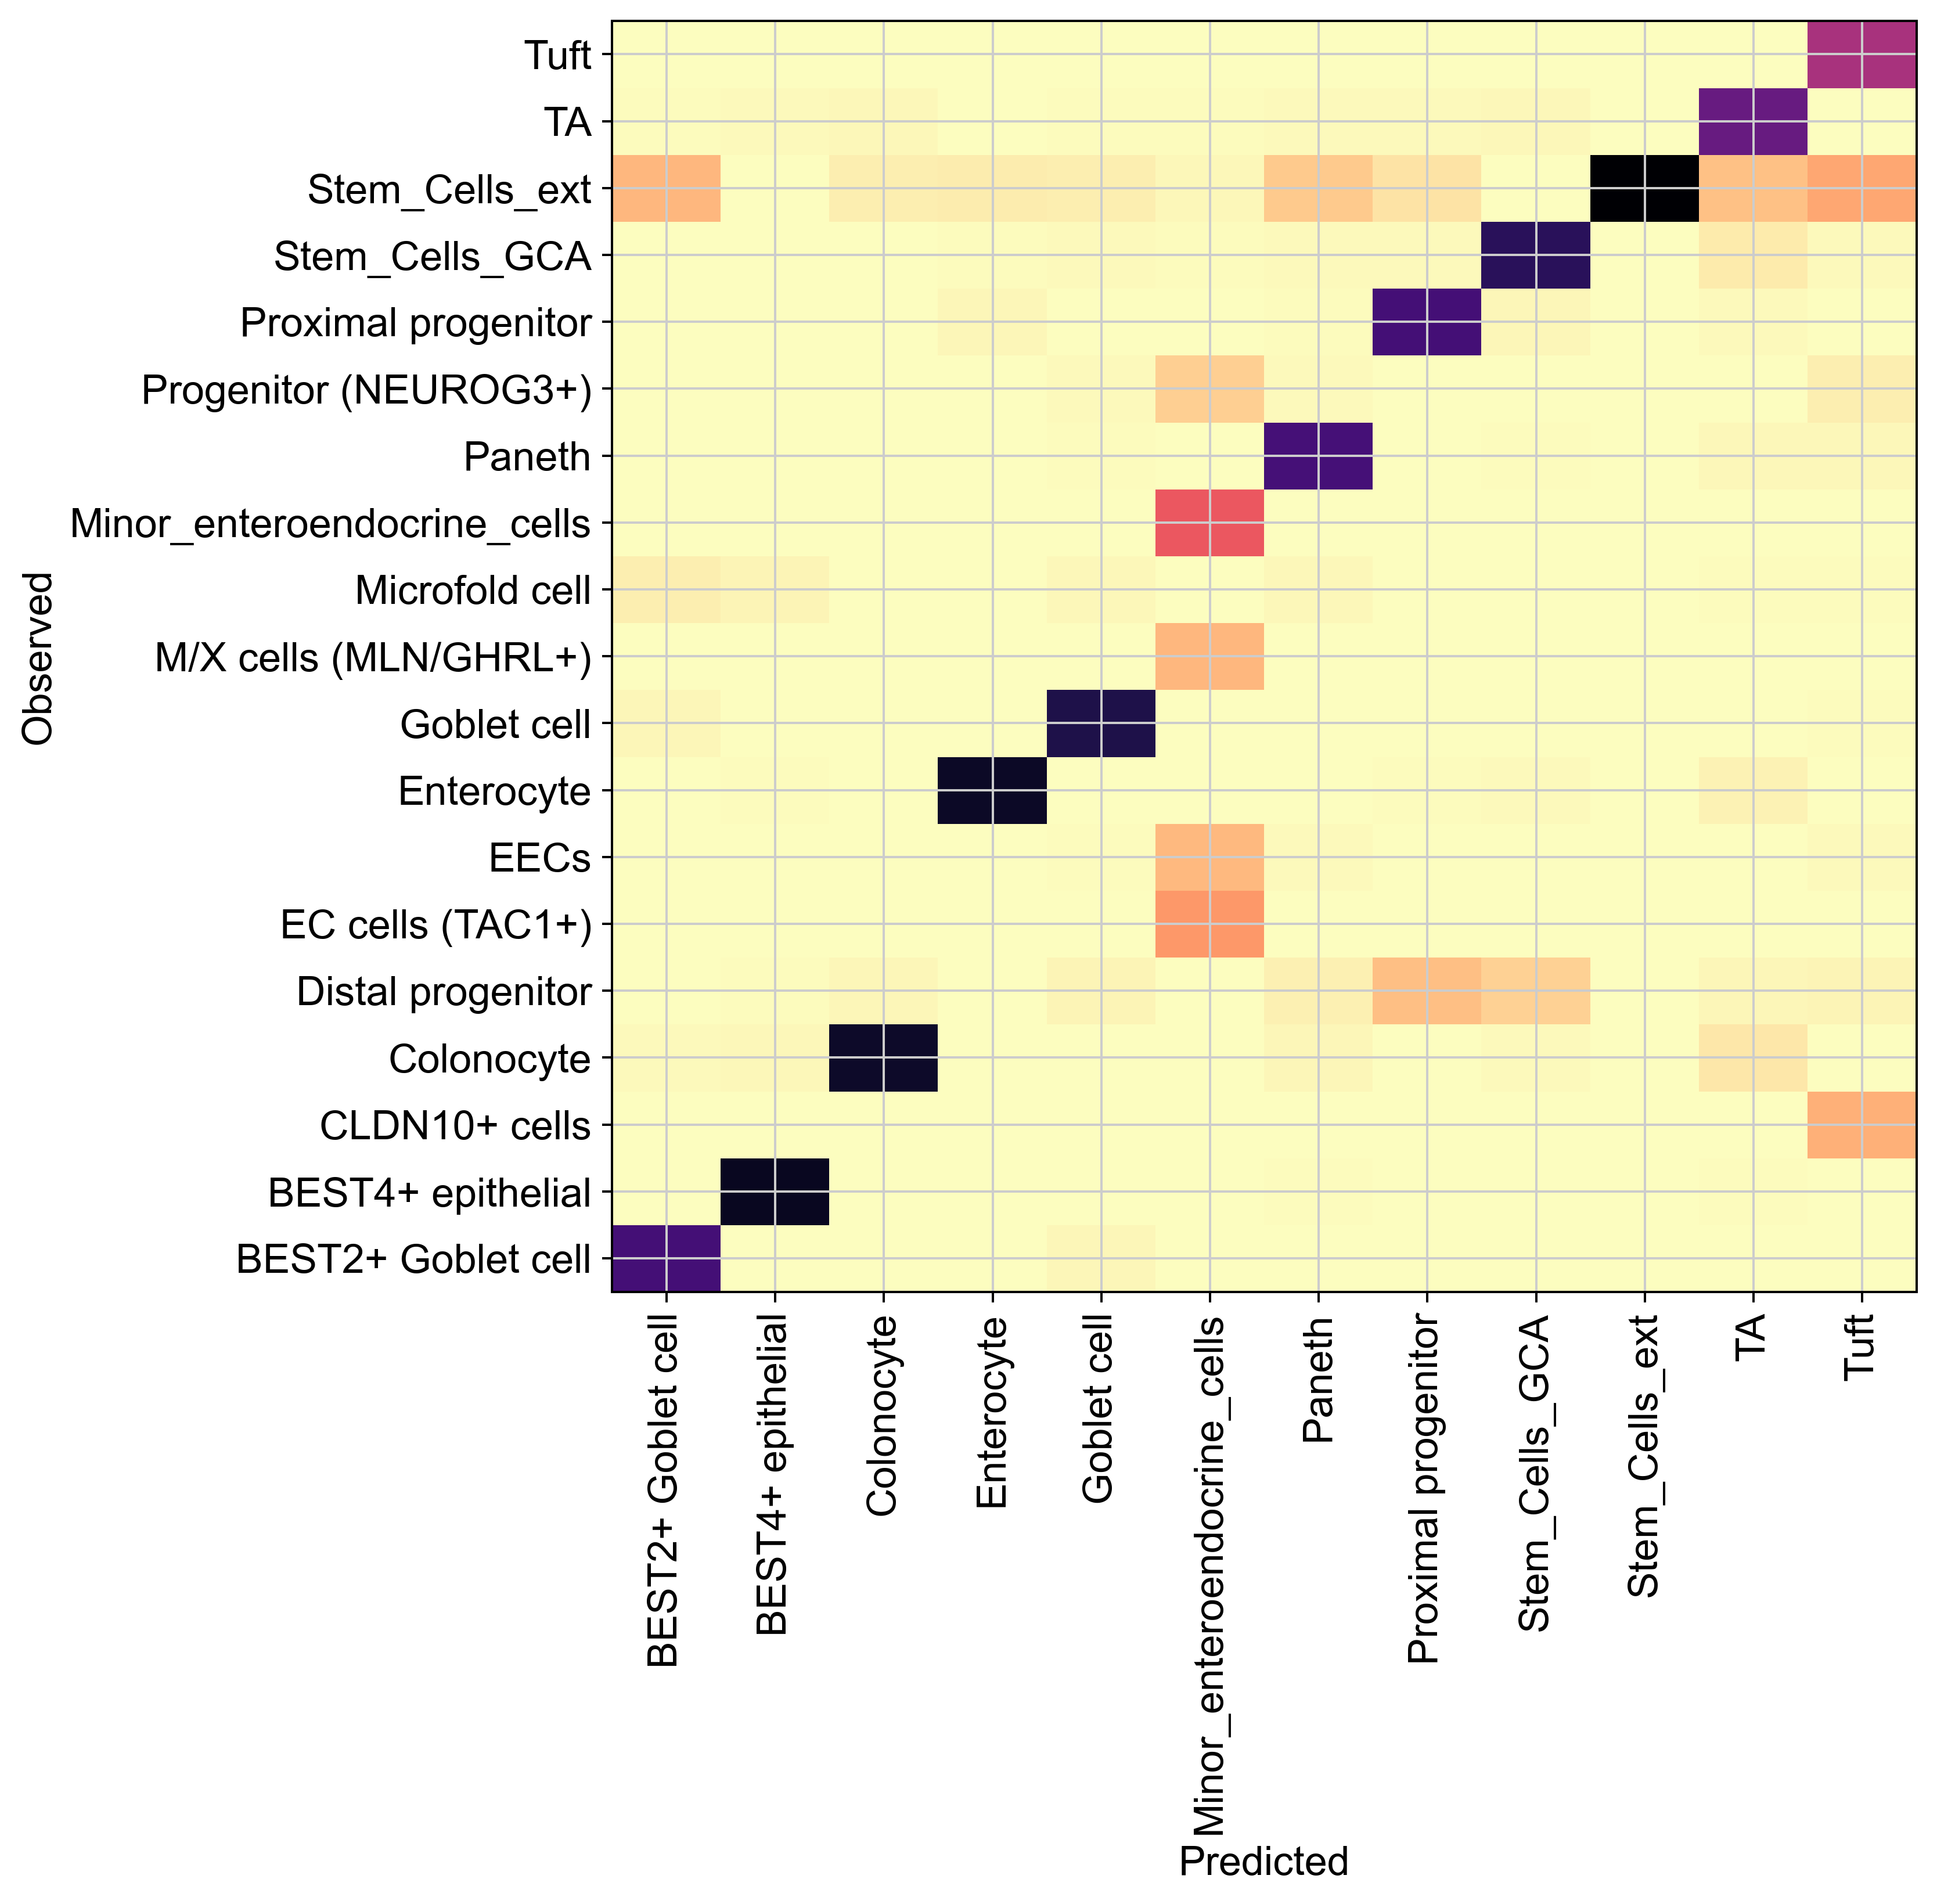

In [49]:
#Validation of the clusters
df = adata.obs.groupby(['Cell States GCA', "C_scANVI"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [50]:
#Calculate accuracy
print(f"Acc: {np.mean(adata.obs['Cell States GCA'].cat.codes == adata.obs.C_scANVI.cat.codes)}")

Acc: 0.10639747321483867
